# 5- Exploitation and graph creation

![steam_logo](https://buy.thewitcher.com/img/shops/steam.svg)

In this section, we will try several combinations in order to form a network composed of nodes and edges. We will take different assumptions to choose our nodes and edges and will try to compare each configuration in order to elect the one we will keep for the rest of the project.

First we import the packages we will need : 

In [23]:
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix

import networkx as nx

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()

In [24]:
pd_data =pd.read_csv('./data/steam_clean.csv')
pd_data.head()

,appid,name,release_date,english,french,german,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success
0,340,Half-Life 2: Lost Coast,2005-10-27,1,1,1,Valve,Valve,windows;mac;linux,0,Single-player;Commentary available;Remote Play...,Action,FPS;Action;Singleplayer,0,6412,1072,123,23,2000000-5000000,0.0,0.0
1,440,Team Fortress 2,2007-10-10,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;Free to Play,Hero Shooter;Free to Play;Multiplayer,520,588020,37107,8895,452,50000000-100000000,0.0,0.0
2,570,Dota 2,2013-07-09,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer,0,1018172,174020,29989,1284,100000000-200000000,0.0,0.0
3,630,Alien Swarm,2010-07-19,1,0,0,Valve,Valve,windows,0,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Free to Play;Co-op;Action,66,17946,974,319,96,1000000-2000000,0.0,0.0
4,730,Counter-Strike: Global Offensive,2012-08-21,1,1,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,FPS;Shooter;Multiplayer,167,3295593,470639,25886,7129,20000000-50000000,0.0,0.0


In [4]:
len(pd_data.owners)

29380

# Cleaning

In [25]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def remove_non_language(df):
    # keep only rows marked as supporting english, french or german
    df = df[df['english']+df['french'] + df['german'] >= 1 ].copy()
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english, french and german column, now redundant
    df = df.drop(['english', 'french','german'], axis=1)
    
    return df

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
         'Local Multi-Player',
         'MMO',
        # 'Mods',
        'Multi-player',
         'Online Co-op',
         'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        'Action',
        'Adventure',
        'Casual',
        'Indie',
        'Massively Multiplayer',
        'RPG',
        'Racing',
        'Simulation',
        'Sports',
        'Strategy', 
        'violent'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)

    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def pre_process(pd_data):
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd_data.copy()
    
    # keep game in english, german or french
    df = remove_non_language(df)
    
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    df['release_month'] = df['release_date'].apply(lambda x: x.month)
    
    # remove average_playtime as deemed not relevant for our analysis in the way it is calculated
    # In fact, the values of those 2 elements are mainly constituted of 0
    df = df.drop(columns=['average_playtime','median_playtime'])
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process(pd_data)
print('Verify no missing values:')
print(data.isnull().sum().value_counts())

data.head()


Verify no missing values:
0    34
1     1
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,340,Half-Life 2: Lost Coast,2005-10-27,Valve,Valve,0,Action,0,6412,1072,2000000,0.0,0.0,7484,0.856761,82.754771,2005,10,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,440,Team Fortress 2,2007-10-10,Valve,Valve,0,Action;Free to Play,520,588020,37107,50000000,0.0,0.0,625127,0.940641,93.217574,2007,10,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,570,Dota 2,2013-07-09,Valve,Valve,0,Action;Free to Play;Strategy,0,1018172,174020,100000000,0.0,0.0,1192192,0.854034,84.770535,2013,7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,630,Alien Swarm,2010-07-19,Valve,Valve,0,Action,66,17946,974,1000000,0.0,0.0,18920,0.948520,92.405605,2010,7,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,730,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,0,Action;Free to Play,167,3295593,470639,20000000,0.0,0.0,3766232,0.875037,87.045099,2012,8,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
#data =pd.read_csv("./data/final_clean_data.csv")
#data.head()

# Data Selection

We are now going to use our knowledge gained from the exploration part to build our graph. Thanks to the machine learning part, we were able to obtain the metrics that influence the most the rating and the economical success of a game. 

We will here only want to consider a subset of our dataset which arethe best rated games. Our goal being to define what makes a popular game from a less popular one, we want to visualize the most successfull games. knowing that the metric **rating** takes into consideration the number of review and the actual opinion of the gamers on the game, we will use this value.

In [27]:
threshold = 2000

We will pick 2000 games from our original dataset here. This way, we will be able to process our data fast enough while having relevant results.

In [28]:
processed = data.sort_values(by=['rating'], ascending=False)[:threshold].reset_index().copy()#
processed.head()
processed.drop(columns='index')

,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,292030,The Witcher® 3: Wild Hunt,2015-05-18,CD PROJEKT RED,CD PROJEKT RED,0,RPG,78,294579,5953,5000000,39.99,299925000.0,300532,0.980192,96.919487,2015,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,427520,Factorio,2016-02-25,Wube Software LTD.,Wube Software LTD.,0,Casual;Indie;Simulation;Strategy;Early Access,38,65700,906,2000000,30.00,105000000.0,66606,0.986398,96.897964,2016,2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
2,105600,Terraria,2011-05-16,Re-Logic,Re-Logic,0,Action;Adventure;Indie;RPG,88,379523,9192,10000000,10.00,150000000.0,388715,0.976353,96.621538,2011,5,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0
3,294100,RimWorld,2018-10-17,Ludeon Studios,Ludeon Studios,0,Indie;Simulation;Strategy,0,56569,1034,1000000,34.50,51750000.0,57603,0.982050,96.393346,2018,10,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,250900,The Binding of Isaac: Rebirth,2014-11-04,"Nicalis, Inc.","Nicalis, Inc.",16,Action,403,91604,1957,2000000,15.00,52500000.0,93561,0.979083,96.347544,2014,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,817860,Perceptions of the Dead 2,2018-06-14,Ithaqua Labs,Ithaqua Labs,0,Adventure;Indie,9,40,0,0,8.25,82500.0,40,1.000000,83.651659,2018,6,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
1996,17570,"Pirates, Vikings, and Knights II",2010-02-12,Octoshark Studios,Octoshark Studios,0,Action;Free to Play;Indie,251,4227,630,1000000,0.00,0.0,4857,0.870290,83.649161,2010,2,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1997,235250,Super Sanctum TD,2013-05-09,Coffee Stain Studios,Coffee Stain Publishing,0,Casual;Indie;Strategy,27,1289,166,200000,5.00,1750000.0,1455,0.885911,83.646211,2013,5,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0
1998,877810,Anodyne 2: Return to Dust,2019-08-12,Sean Han Tani;Marina Kittaka,Analgesic Productions,0,Adventure;Indie;RPG,14,205,16,0,19.50,195000.0,221,0.927602,83.639884,2019,8,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0


We will then drop the values that are of little interest as shown during the exploration phase.

In [29]:
processed = processed.drop(columns=['release_date','required_age', 'achievements','positive_ratings','negative_ratings', 'appid'])
processed = processed.dropna()

In order to be able to do our graph with values that have a wide range, we will use a logarithmic scale for the **economic_success**, the number of **owners** and the **total_rating** data.

In [30]:
processed['owners'] =  np.log(processed['owners'] + 1)# /10**6
processed['total_ratings'] = np.log(processed['total_ratings']+1)
processed['economic_success'] = np.log(processed['economic_success'] + 1)#/10**6

In [31]:
processed['owners'][0]

15.424948670398354

# Final Dataset after cleaning

In [32]:
processed.head()

,index,name,developer,publisher,genres,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,1875,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,RPG,15.424949,39.99,19.519043,12.613313,0.980192,96.919487,2015,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,6320,Factorio,Wube Software LTD.,Wube Software LTD.,Casual;Indie;Simulation;Strategy;Early Access,14.508658,30.00,18.469471,11.106565,0.986398,96.897964,2016,2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
2,80,Terraria,Re-Logic,Re-Logic,Action;Adventure;Indie;RPG,16.118096,10.00,18.826146,12.870604,0.976353,96.621538,2011,5,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0
3,1945,RimWorld,Ludeon Studios,Ludeon Studios,Indie;Simulation;Strategy,13.815512,34.50,17.761935,10.961347,0.982050,96.393346,2018,10,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,889,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",Action,14.508658,15.00,17.776324,11.446380,0.979083,96.347544,2014,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0


# Graph construction

**What we want to achieve:** We are trying to define a graph to depict the success o our games. Our metrics will be the logarithm of the economic success and the rating of the games. Using the economic success obliges us to remove the free games from our graph.


We wanted at first to use a metric such as the number of owners but due to the discrete value of such a metric, we could not get any significant result. Also, we don't have any information about any in-game payment or advertisement inside of the free to play game which can create a bias in our analysis.

Also, the economic success is a really useful metic to describe a phenomenon difficult to represent with our data : "advertising". In fact, we can assume that a studio that is gaining more money will be able to invest more into advertising to increase the success of their game. This metric is solely based on the number of sale and the price of the game. Hence, it is a good addition to our metric "rating" which is solely based on the perceived quality of a game.  

In [33]:
new_data = processed.copy()
new_data = new_data[new_data.price > 0 ]

categories = ['release_year', 'publisher','name', 'developer', 'owners', 'rating','release_month', 'price',   'adventure', 'action', 'casual', 'indie', 'massively_multiplayer', 'rpg', 'racing', 'simulation', 'sports', 'strategy','violent']
new_data.head()


,index,name,developer,publisher,genres,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,release_month,local_multi_player,mmo,multi_player,online_co_op,online_multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,violent
0,1875,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,RPG,15.424949,39.99,19.519043,12.613313,0.980192,96.919487,2015,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,6320,Factorio,Wube Software LTD.,Wube Software LTD.,Casual;Indie;Simulation;Strategy;Early Access,14.508658,30.00,18.469471,11.106565,0.986398,96.897964,2016,2,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
2,80,Terraria,Re-Logic,Re-Logic,Action;Adventure;Indie;RPG,16.118096,10.00,18.826146,12.870604,0.976353,96.621538,2011,5,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0
3,1945,RimWorld,Ludeon Studios,Ludeon Studios,Indie;Simulation;Strategy,13.815512,34.50,17.761935,10.961347,0.982050,96.393346,2018,10,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,889,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",Action,14.508658,15.00,17.776324,11.446380,0.979083,96.347544,2014,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0


We must first rescale our data to ensure that the scale is similar for both of them.

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X = np.array(new_data[['rating', 'economic_success']])
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

We will here use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [35]:
# Create a similarity matrix based on the exponential of the euclidean distance between the games 

def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    sq_dist = pdist(X)
    pairwise_dists = squareform(sq_dist)**2
    adjacency = np.exp( -pairwise_dists / (2*sigma**2) - np.identity(len(pairwise_dists)))

    threshold = adjacency < epsilon

    adjacency[threshold]=0
    
    return adjacency

In [36]:
sigma = np.std(pdist(X))
print(f'The value of sigma is {sigma}')

The value of sigma is 0.6248180955863321


(array([1028568.,  370862.,  279520.,  237628.,  211536.,  193938.,
         184070.,  178374.,  173160.,  176908.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

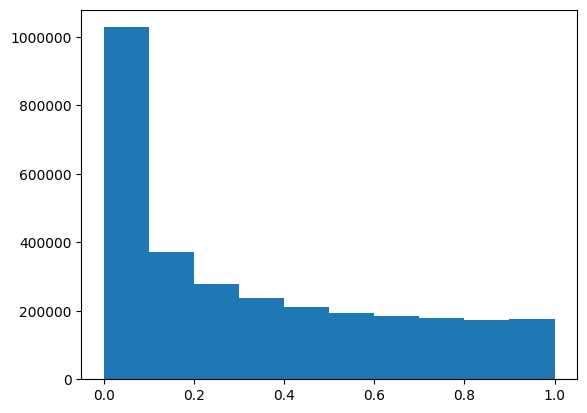

In [37]:
sq_dist = pdist(X)
pairwise_dists = squareform(sq_dist)**2
adjacency = np.exp( -pairwise_dists / sigma**2 / 2) - np.identity(len(pairwise_dists))
plt.hist(adjacency.flatten())

We make sure to choose an epsilon that removes the unwanted corresponding edges weights and puts them to 0. A sparse matrix is obtained when increasing epsilon (without exceeding a certain value in risk of for a certain value of sigma).

In [53]:
epsilon =0.85

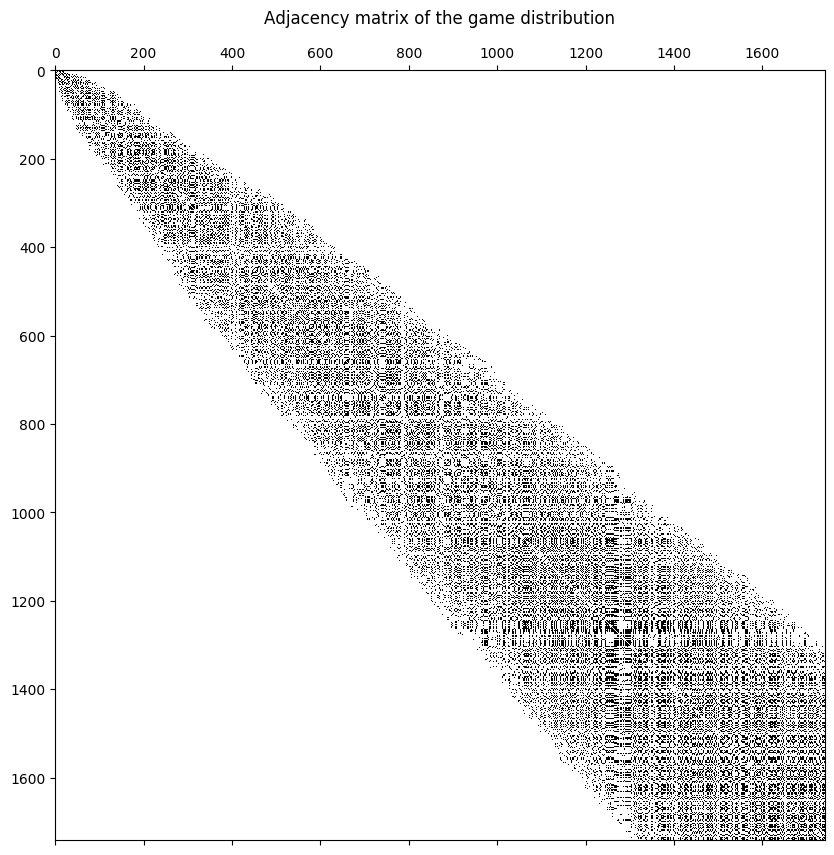

In [54]:
adjacency = epsilon_similarity_graph(X,sigma,epsilon)
plt.figure(1, figsize=(10, 10))
plt.spy(adjacency)

plt.title('Adjacency matrix of the game distribution')
plt.show()

With our adjacency matrix, it seems that our network is connected with one giant component. Moreover, it seems that it is build in a pyramid fashion with the best rated games at the tip of the pyramid. 

We can also see some patern inside of our adjacency matrix which shows that there is more interactions between some games of the same `group` within our giant component. We will try to discretize those groups later on in the clustering part.

In [55]:
Graph = nx.from_numpy_array(adjacency)
nodes1 = new_data[categories]

node_props = nodes1.to_dict()
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(Graph, node_props[key], key)
    
nx.write_gexf(Graph, 'graphs/our_graph'+str(threshold)+'.gexf')

## Analysis of the obtained graph 

(array([127., 197., 211., 214., 297., 199., 170., 126., 128.,  73.]),
 array([  2.71139464,  32.89256435,  63.07373405,  93.25490375,
        123.43607345, 153.61724315, 183.79841285, 213.97958255,
        244.16075225, 274.34192195, 304.52309165]),
 <a list of 10 Patch objects>)

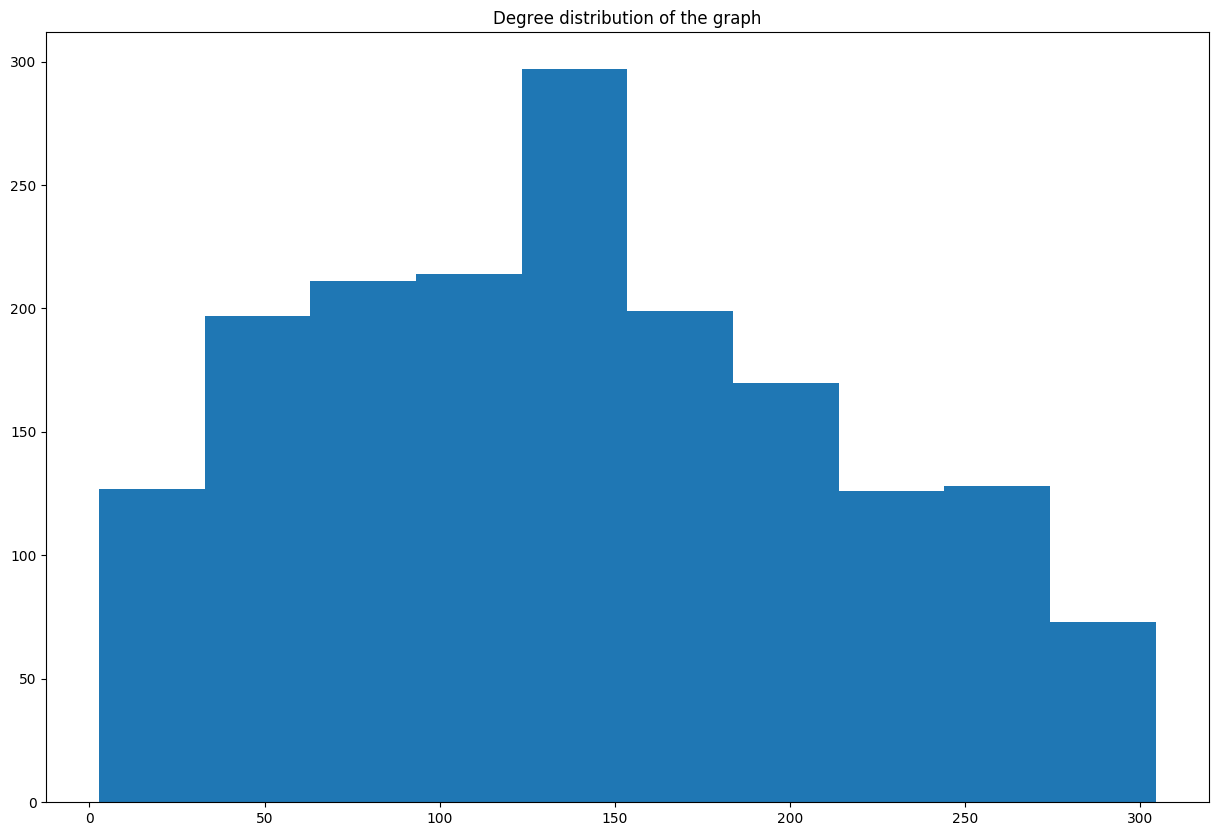

In [56]:
degrees_graph = np.sum(adjacency,axis=0) 

plt.figure(1, figsize=(15, 10))
plt.title('Degree distribution of the graph')
plt.hist(degrees_graph)

In [57]:
moment_1 = np.sum(np.nonzero(adjacency))/adjacency.shape[0]
moment_2 = np.sum( np.power(np.sum(np.nonzero(adjacency),0),2))/adjacency.shape[0]

print("Citation graph first moment:", moment_1)
print("Citation graph second moment:", moment_2)

Citation graph first moment: 308631.3811710677
Citation graph second moment: 741310773.4087256


The moments are giving us an information about the distribution of the edges between the nodes. 

The moment of order 1 give an information on the dostribution of the graph while the moment of order 2 gives us an information on the variance of these connection. In our case, the variance of the distribution is really high and seems to be evenly connected.

In [58]:
num_edges = int(np.count_nonzero(adjacency)/2 )
print(f"Number of edges in the graph: {num_edges}")

Number of edges in the graph: 131162


In [59]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)


giant_component = max(connected_component_subgraphs(Graph), key=len) 
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_component.number_of_nodes(), giant_component.size()))

The giant component of the citation graph has 1742 nodes and 131162 edges.


From this, we can say that our graph is connected. There is no clear separation different element. From those values and the results that we were able to export from our graph, we deduced that our graph is probably related to the **small world model**.

In [60]:
nx.average_clustering(Graph)

0.6432014455743111

The clustering coefficient gives us information on how much related are the points within the network. Indeed, it chooses each node at random and check its connectivity with two other nodes, forming a triangle. Then, it calculates the clustering coefficient by taking the mean of all the found clustering coefficient. In this case, the citation graph gives us a coefficient of approx. 63%, which means that a 2 third of the graph is connected. This result is going in the direction of our assumption for the small graph network. Our graph is not fully connected but all of the elements are connected between each others. 


# Graph analysis and clustering 

**What we want to achieve:** We are trying to define a clustering technique based on the success of our game. We will use the adjacency matrix and the values of the array X (**raitings** and **economic_success**) defined in the previous part.

Before doing anything, we will plot our data to see what it looks like in order to identify the presence of visible clusters. We will then define our clustering technique based on our observations.

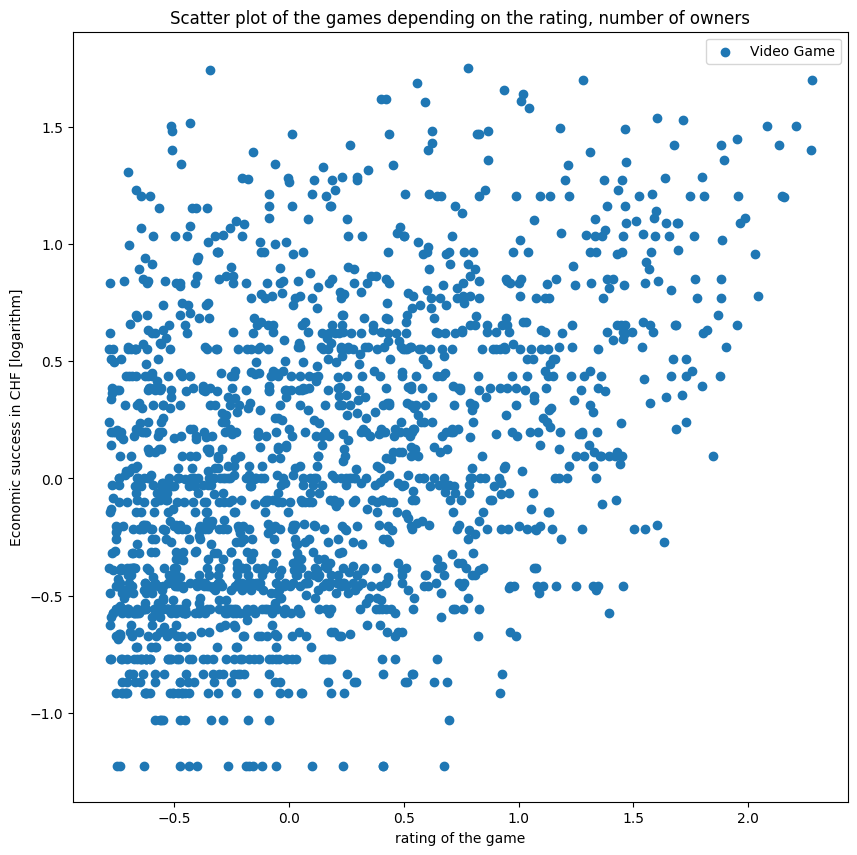

In [61]:
from sklearn.cluster import KMeans

plt.figure(1, figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("rating of the game")
plt.ylabel("Economic success in CHF [logarithm]")
plt.title('Scatter plot of the games depending on the rating, number of owners' )
plt.legend(["Video Game"])
plt.show()

From this scatter plot, we can see that our data is quite sparse without any apparent cluster. For this, we decided to go for a spectral analysis of our graph to see if some underlying fature will be discovered with our data.

# Spectral analysis 

We will here use the preprocessed parameters to cluster our data. Finally, we will analyze the results that we are obtaining and we will compare them with the graph obtained with gephi.

In [62]:
# eigenvalue and eigenvector decomposition
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)
    # Your code here
    return lamb, U

# number of connected components (in our case, number of clusters)
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return np.sum(lamb<threshold)

#Computation of the Laplacian
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    distance = np.array([np.sum(adjacency,0)])
    laplacian = np.diag(distance[0]) - adjacency
    
    if (normalize):
        laplacian=np.power(distance,-1/2)*laplacian*np.power(distance,-1/2)
        laplacian[np.isnan(laplacian)] = 0
    return laplacian


# Function to perform the spectral clustering 

class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  1# Your code here
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency,self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)

    
    
        nb = compute_number_connected_components(self.e, threshold=10**(-10))
        if (self.normalize):
            T = self.U / np.linalg.norm(self.U, ord=2, axis=1, keepdims=True)  
            kmeans = KMeans(n_clusters=self.n_classes, n_init=20, max_iter=600, random_state=0).fit(T[:,:self.n_classes])
        else:
            kmeans = KMeans(n_clusters=self.n_classes, n_init=20, max_iter=600, random_state=0).fit(self.U[:,:self.n_classes])
        y_pred =  kmeans.labels_# Vector with cluster assignments
        return y_pred

We are here computing the normalized Laplacian $Ln = I - D^{-1/2}W D^{-1/2} = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. 



The normalized Laplacian graph was choosen for this exercise as it provides a better numerical stability. In fact, its values are always borned between [0,2].

In [63]:
laplacian_norm = compute_laplacian(adjacency, normalize=True)

In [64]:
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

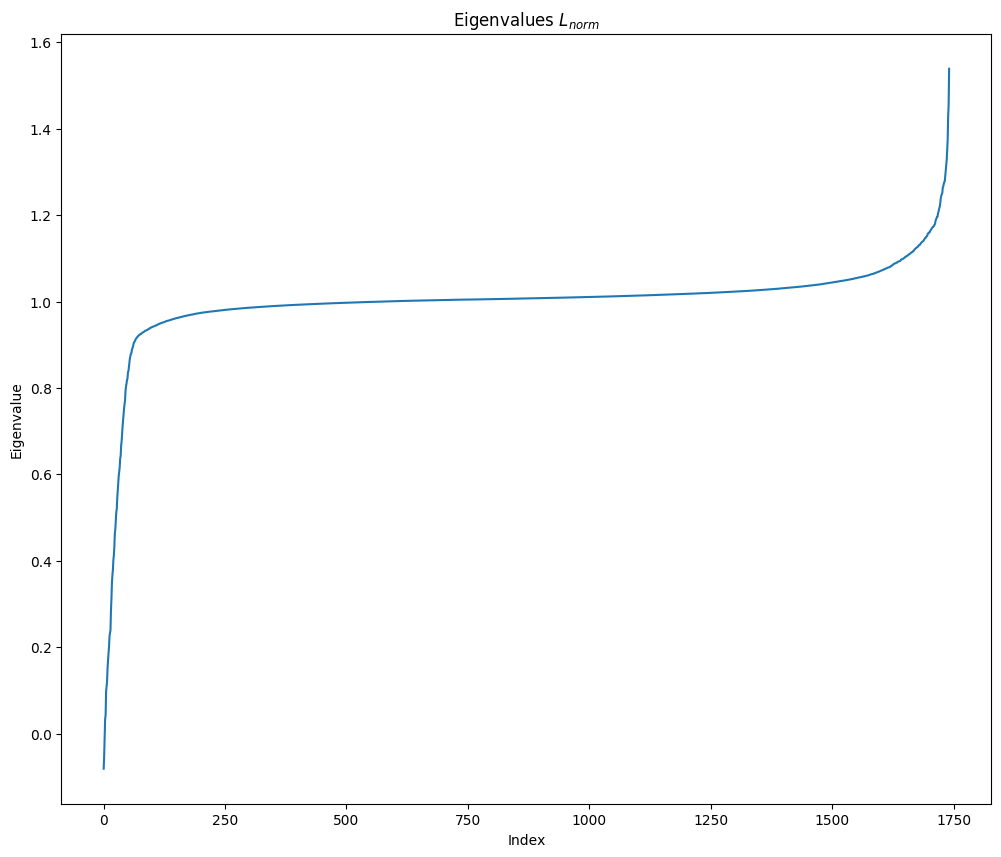

In [65]:
plt.figure(figsize=(12,10))

plt.plot(np.sort(lamb_norm))
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [66]:
print(compute_number_connected_components(lamb_norm, threshold=1e-12))

3


Thanks to our function `compute_number_connected_components`, we are able to obtain the number of Connected component in our network. In the next part, we will then cluster our data with 3 main clusters.

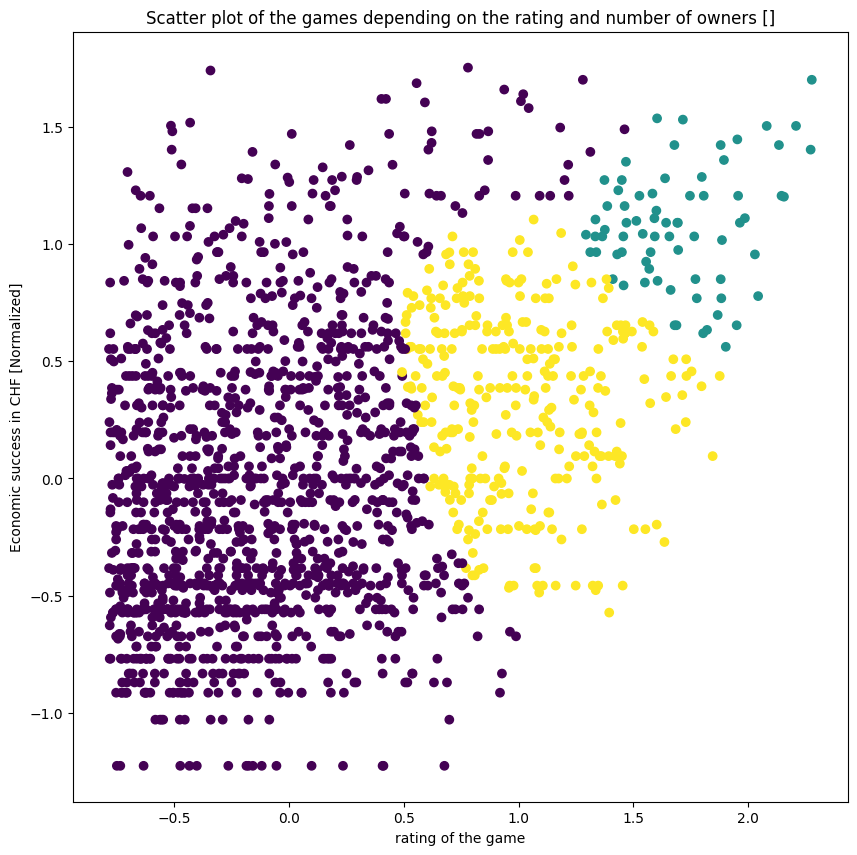

In [67]:
spectral_clustering = SpectralClustering(n_classes=3, normalize=True)
y_pred = spectral_clustering.fit_predict(epsilon_similarity_graph(X, sigma=sigma, epsilon=epsilon))

plt.figure(1, figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.xlabel("rating of the game")
plt.ylabel("Economic success in CHF [Normalized]")
plt.title('Scatter plot of the games depending on the rating and number of owners []' )
plt.show()

## Analysis of our results and Conclusion 

At the end of our work, we can see  a pyramidal structure for our games:

- The first category, in yellow are the game That have the best grade out of all the other games. We can definitely see that here, havi ng an huge grade is synonom of being a huge economic success with a large community of gamers buying this game whatever its price. 

- The seconf category in purple are the games with a really good grades and a pretty good economic success.

- The last category of games in blue have the largest economic success span of all of the clusters. This cluster is our largest cluster.

This plot in itself gives us informations about probably the most important criteria of steem which is the user's rating and the way a game is promoted by the playe's community. In fact, as can be seen here, a good rating is always correlated with an huge number of sales which will increase the economic success of the game. 

To complete our analysis, we used [Gephi](https://gephi.org/), to visualize our graph based on the Ley Dan method. The result is presented below.

![Modularity graph](images/modularity_graph.jpeg)

This graph enhence the connected and higly similar communities within each color groups. We can therefore find that this graph is highly similar to our previous clustering technique. The similarity is mainly based on the number of owners and the rating of those games. 

Through our graph analysis, we were not able to find a given parameter that explained the success of a game. We were able to show the huge dependency of the number of owners and the overall rating of a game.

It currently seems that the high success rate of a video games depends on parameters that could not be depicted with the provided data of steam. The marketing of a game, the promotion plan and advertisment and review could be a critical criteria to define the success of a game . 

One thing that our study showed was the fact that ultimately, the success of a game was determined by how good it will be received by the gamer's community. The rating of a game defines its success

In today's society where there is more video games than there has ever been, the ratings are the only parameters that are able to classify games worth playing from other games. 